In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [13]:
# Load the dataset
df = pd.read_csv('customer_churn_data.csv') 

# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes)

print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Handle missing values if any
if df.isnull().sum().sum() > 0:
    print("\nHandling missing values...")
    # For numerical columns - fill with median
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    
    # For categorical columns - fill with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    print("Missing values handled successfully!")
else:
    print("No missing values found!")

# Summary statistics
print("\nSummary Statistics for Numerical Features:")
print(df.describe())

print("\nSummary Statistics for Categorical Features:")
print(df.describe(include='object'))

Dataset Shape: (10000, 24)

Column Names:
['customer_id', 'age', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'customer_satisfaction', 'support_calls', 'churn']

Data Types:
customer_id               object
age                        int64
gender                    object
senior_citizen             int64
partner                   object
dependents                object
tenure                     int64
phone_service             object
multiple_lines            object
internet_service          object
online_security           object
online_backup             object
device_protection         object
tech_support              object
streaming_tv              object
streaming_movies          object
contract                  obj

Churn Distribution:
churn
No     7728
Yes    2272
Name: count, dtype: int64

Overall Churn Rate: 22.72%


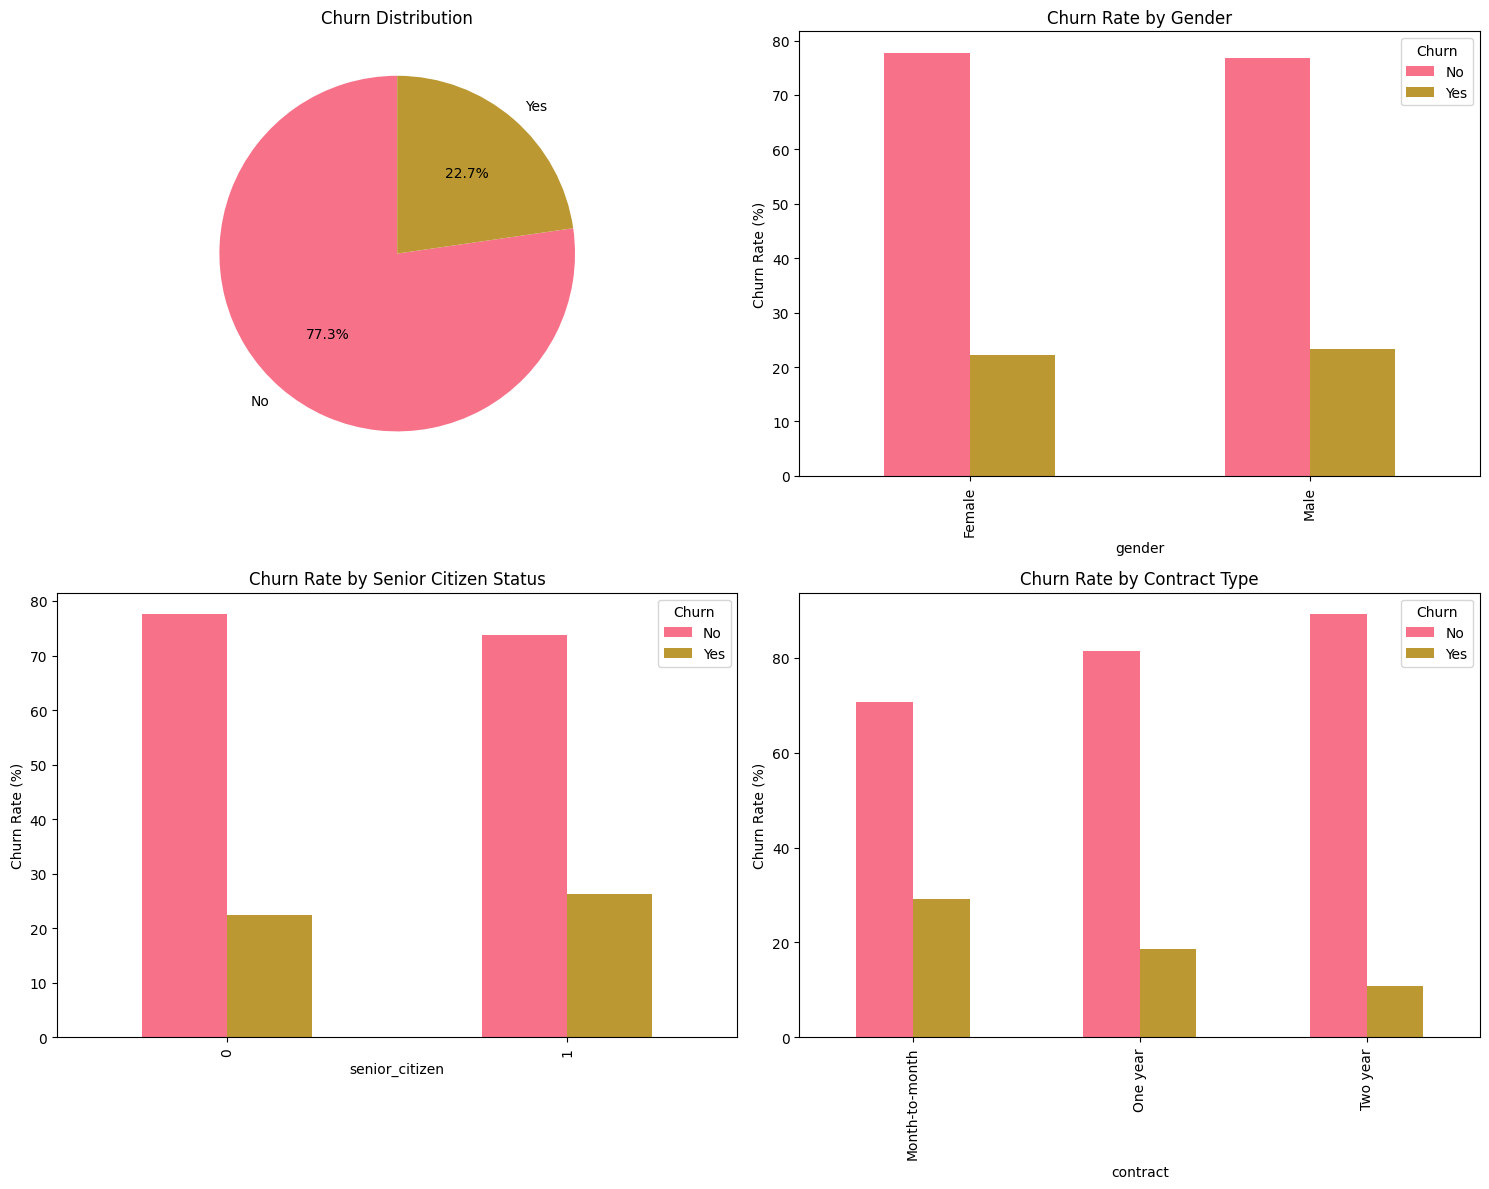


Demographic Analysis:

AGE vs Churn:
Average age for churned customers: 45.42
Average age for retained customers: 44.44

GENDER vs Churn:
churn      No    Yes
gender              
Female  77.80  22.20
Male    76.78  23.22

SENIOR_CITIZEN vs Churn:
churn              No    Yes
senior_citizen              
0               77.64  22.36
1               73.78  26.22

PARTNER vs Churn:
churn       No    Yes
partner              
No       76.09  23.91
Yes      78.36  21.64

DEPENDENTS vs Churn:
churn          No    Yes
dependents              
No          75.73  24.27
Yes         80.89  19.11

Service Usage Impact Analysis:


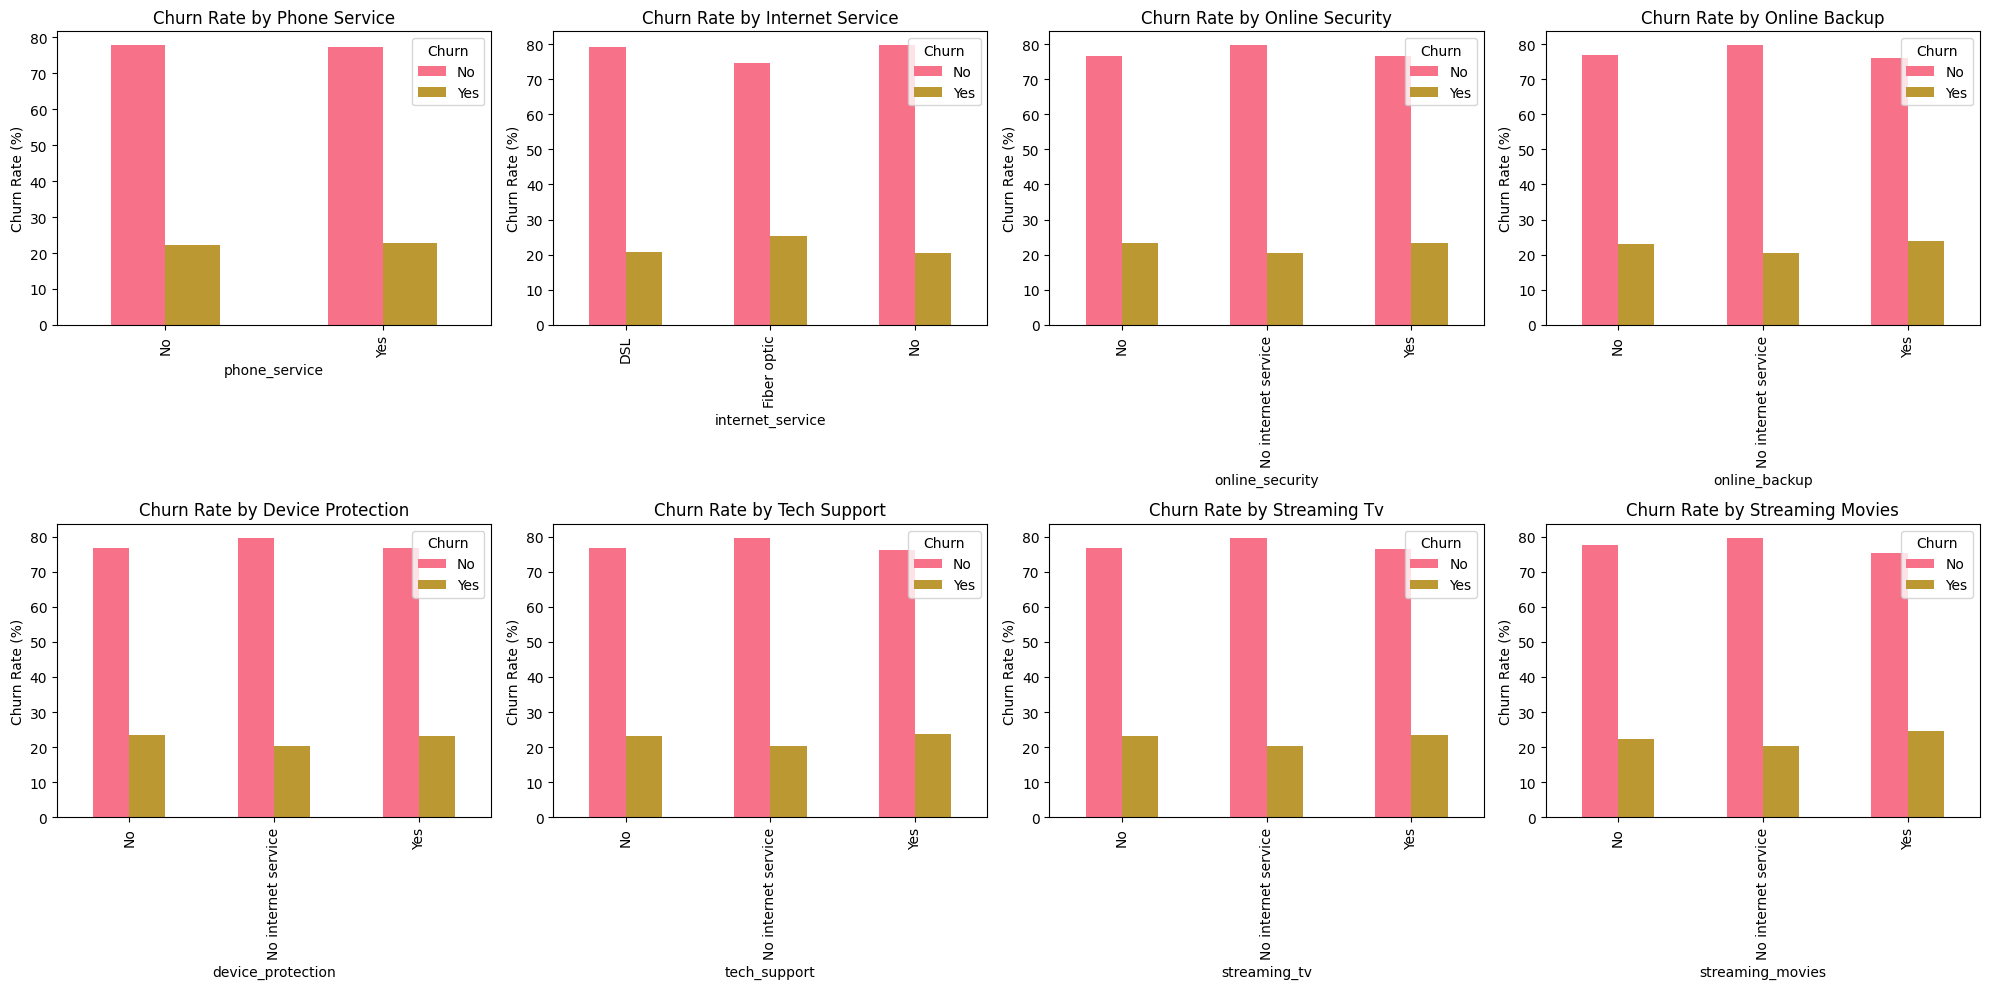


Financial Factors Analysis:


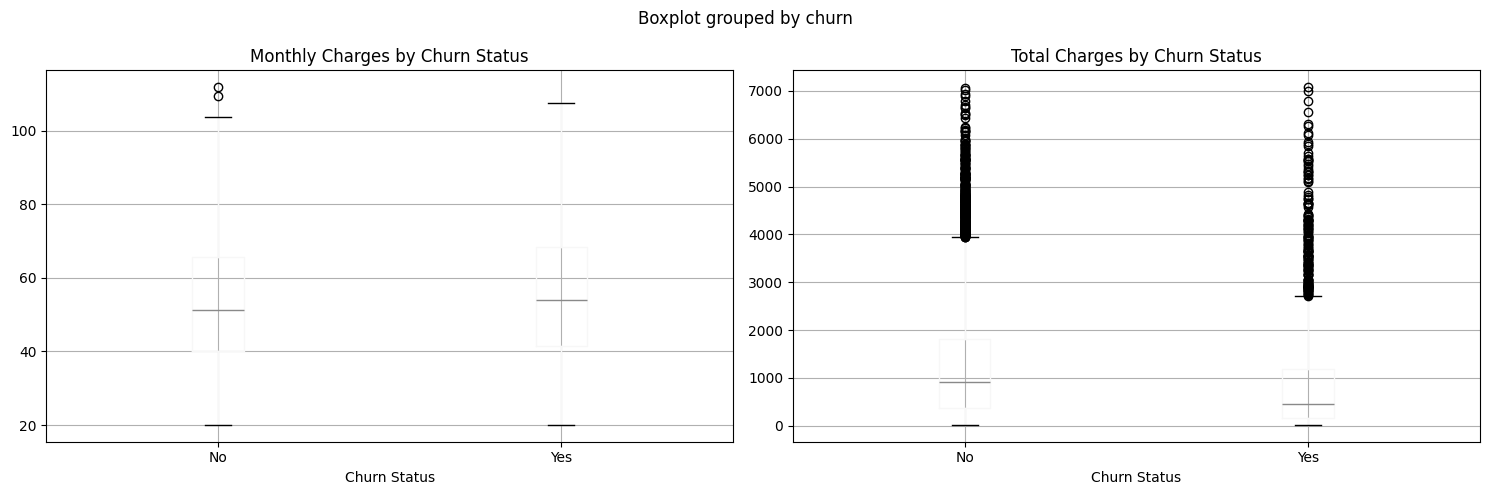


Payment Method Analysis:
churn                         No    Yes
payment_method                         
Bank transfer (automatic)  79.84  20.16
Credit card (automatic)    79.95  20.05
Electronic check           72.76  27.24
Mailed check               79.11  20.89


<Figure size 1000x600 with 0 Axes>

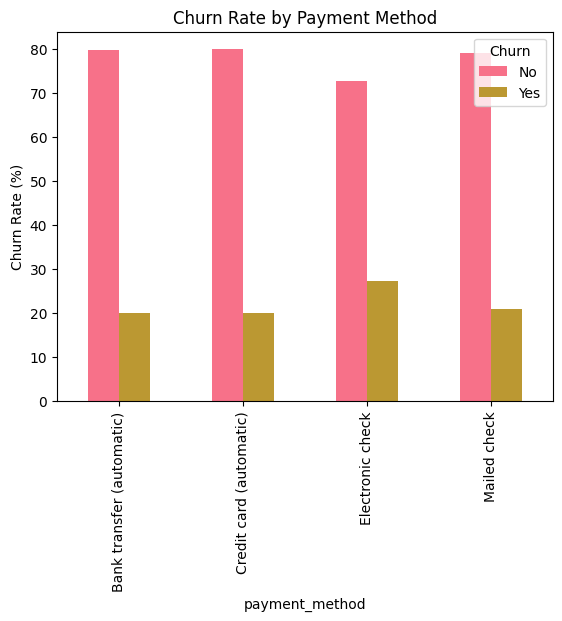


Correlation Analysis:


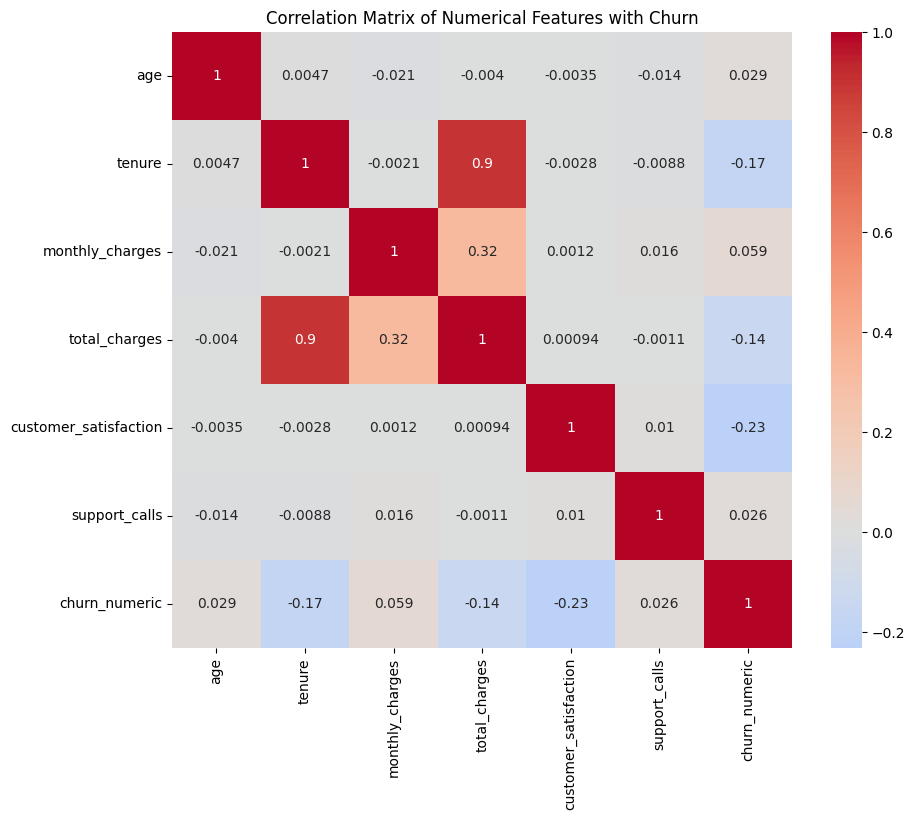

Top correlations with churn:
customer_satisfaction    0.232639
tenure                   0.173547
total_charges            0.141451
monthly_charges          0.058919
age                      0.028541
support_calls            0.025834
Name: churn_numeric, dtype: float64


In [14]:
# Analyze churn distribution
print("Churn Distribution:")
churn_counts = df['churn'].value_counts()
print(churn_counts)

churn_rate = (churn_counts['Yes'] / len(df)) * 100
print(f"\nOverall Churn Rate: {churn_rate:.2f}%")

# Visualize churn distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Churn distribution
axes[0,0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Churn Distribution')

# Churn by gender
churn_gender = pd.crosstab(df['gender'], df['churn'], normalize='index') * 100
churn_gender.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Churn Rate by Gender')
axes[0,1].set_ylabel('Churn Rate (%)')
axes[0,1].legend(title='Churn')

# Churn by senior citizen
churn_senior = pd.crosstab(df['senior_citizen'], df['churn'], normalize='index') * 100
churn_senior.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Churn Rate by Senior Citizen Status')
axes[1,0].set_ylabel('Churn Rate (%)')
axes[1,0].legend(title='Churn')

# Churn by contract type
churn_contract = pd.crosstab(df['contract'], df['churn'], normalize='index') * 100
churn_contract.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Churn Rate by Contract Type')
axes[1,1].set_ylabel('Churn Rate (%)')
axes[1,1].legend(title='Churn')

plt.tight_layout()
plt.show()

# Demographic analysis
print("\nDemographic Analysis:")
demographic_cols = ['age', 'gender', 'senior_citizen', 'partner', 'dependents']

for col in demographic_cols:
    if col in df.columns:
        print(f"\n{col.upper()} vs Churn:")
        if df[col].dtype == 'object' or col == 'senior_citizen':
            churn_analysis = pd.crosstab(df[col], df['churn'], normalize='index') * 100
            print(churn_analysis.round(2))
        else:
            print(f"Average {col} for churned customers: {df[df['churn']=='Yes'][col].mean():.2f}")
            print(f"Average {col} for retained customers: {df[df['churn']=='No'][col].mean():.2f}")

# Service usage impact analysis
print("\nService Usage Impact Analysis:")
service_cols = ['phone_service', 'internet_service', 'online_security', 'online_backup', 
                'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(service_cols):
    if col in df.columns:
        churn_service = pd.crosstab(df[col], df['churn'], normalize='index') * 100
        churn_service.plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Churn Rate by {col.replace("_", " ").title()}')
        axes[i].set_ylabel('Churn Rate (%)')
        axes[i].legend(title='Churn')

plt.tight_layout()
plt.show()

# Financial factors analysis
print("\nFinancial Factors Analysis:")
financial_cols = ['monthly_charges', 'total_charges']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, col in enumerate(financial_cols):
    if col in df.columns:
        # Convert to numeric if needed
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df.boxplot(column=col, by='churn', ax=axes[i])
        axes[i].set_title(f'{col.replace("_", " ").title()} by Churn Status')
        axes[i].set_xlabel('Churn Status')

plt.tight_layout()
plt.show()

# Payment method analysis
if 'payment_method' in df.columns:
    print("\nPayment Method Analysis:")
    payment_churn = pd.crosstab(df['payment_method'], df['churn'], normalize='index') * 100
    print(payment_churn.round(2))
    
    plt.figure(figsize=(10, 6))
    payment_churn.plot(kind='bar')
    plt.title('Churn Rate by Payment Method')
    plt.ylabel('Churn Rate (%)')
    plt.legend(title='Churn')
    plt.show()

# Correlation analysis for numerical features
print("\nCorrelation Analysis:")
numerical_cols = ['age', 'tenure', 'monthly_charges', 'total_charges', 'customer_satisfaction', 'support_calls']
numerical_data = df[numerical_cols + ['churn']].copy()

# Convert churn to numerical for correlation
numerical_data['churn_numeric'] = (numerical_data['churn'] == 'Yes').astype(int)
correlation_matrix = numerical_data[numerical_cols + ['churn_numeric']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features with Churn')
plt.show()

print("Top correlations with churn:")
churn_corr = correlation_matrix['churn_numeric'].abs().sort_values(ascending=False)
print(churn_corr[1:])  # Exclude self-correlation

In [15]:
# Create a copy for preprocessing
df_processed = df.copy()

# Remove customer_id as it's not useful for prediction
if 'customer_id' in df_processed.columns:
    df_processed = df_processed.drop('customer_id', axis=1)

# Convert total_charges to numeric if it's not already
if 'total_charges' in df_processed.columns:
    df_processed['total_charges'] = pd.to_numeric(df_processed['total_charges'], errors='coerce')
    df_processed['total_charges'].fillna(df_processed['total_charges'].median(), inplace=True)

# Encode categorical variables
label_encoders = {}
categorical_columns = df_processed.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col != 'churn']  # Exclude target

print("Encoding categorical variables...")
for column in categorical_columns:
    le = LabelEncoder()
    df_processed[column] = le.fit_transform(df_processed[column])
    label_encoders[column] = le

# Encode target variable
target_encoder = LabelEncoder()
df_processed['churn'] = target_encoder.fit_transform(df_processed['churn'])
print("Target variable encoded: No=0, Yes=1")

# Feature engineering
print("\nFeature Engineering...")

# Create new features
if 'monthly_charges' in df_processed.columns and 'total_charges' in df_processed.columns:
    df_processed['avg_monthly_charges'] = df_processed['total_charges'] / (df_processed['tenure'] + 1)  # +1 to avoid division by zero

if 'support_calls' in df_processed.columns:
    df_processed['high_support_calls'] = (df_processed['support_calls'] > df_processed['support_calls'].quantile(0.75)).astype(int)

if 'customer_satisfaction' in df_processed.columns:
    df_processed['low_satisfaction'] = (df_processed['customer_satisfaction'] < df_processed['customer_satisfaction'].quantile(0.25)).astype(int)

print("New features created:")
print("- avg_monthly_charges: Average monthly charges based on total charges and tenure")
print("- high_support_calls: Binary feature for customers with high support calls")
print("- low_satisfaction: Binary feature for customers with low satisfaction scores")

# Separate features and target
X = df_processed.drop('churn', axis=1)
y = df_processed['churn']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"\nData split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples") 
print(f"Test set: {X_test.shape[0]} samples")

# Scale numerical features
scaler = StandardScaler()
numerical_features = X.select_dtypes(include=[np.number]).columns

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("Feature scaling completed!")

Encoding categorical variables...
Target variable encoded: No=0, Yes=1

Feature Engineering...
New features created:
- avg_monthly_charges: Average monthly charges based on total charges and tenure
- high_support_calls: Binary feature for customers with high support calls
- low_satisfaction: Binary feature for customers with low satisfaction scores

Feature matrix shape: (10000, 25)
Target vector shape: (10000,)

Data split completed:
Training set: 6000 samples
Validation set: 2000 samples
Test set: 2000 samples
Feature scaling completed!


In [16]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Define hyperparameters for tuning
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}

# Train and tune models
best_models = {}
best_scores = {}

print("Training and tuning models...")

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for SVM and Logistic Regression, original for tree-based models
    if name in ['SVM', 'Logistic Regression']:
        X_train_use = X_train_scaled
        X_val_use = X_val_scaled
    else:
        X_train_use = X_train
        X_val_use = X_val
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        model, 
        param_grids[name], 
        cv=5, 
        scoring='f1',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_use, y_train)
    
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best CV F1 Score: {grid_search.best_score_:.4f}")

print("\nModel training completed!")


Training and tuning models...

Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
Best CV F1 Score: 0.3321

Training Decision Tree...


/Users/aditya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/aditya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/aditya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/aditya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/aditya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/aditya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/aditya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:2

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV F1 Score: 0.3695

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best CV F1 Score: 0.3032

Training SVM...
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV F1 Score: 0.3453

Model training completed!


Evaluating models on validation set...
--------------------------------------------------------------------------------

Logistic Regression Results:
Accuracy:  0.7890
Precision: 0.5889
Recall:    0.2335
F1-Score:  0.3344

Decision Tree Results:
Accuracy:  0.7385
Precision: 0.3994
Recall:    0.3018
F1-Score:  0.3438

Random Forest Results:
Accuracy:  0.7900
Precision: 0.6076
Recall:    0.2115
F1-Score:  0.3137

SVM Results:
Accuracy:  0.7510
Precision: 0.4231
Recall:    0.2665
F1-Score:  0.3270

Model Comparison Summary:
                     Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.7890     0.5889  0.2335    0.3344
Decision Tree          0.7385     0.3994  0.3018    0.3438
Random Forest          0.7900     0.6076  0.2115    0.3137
SVM                    0.7510     0.4231  0.2665    0.3270


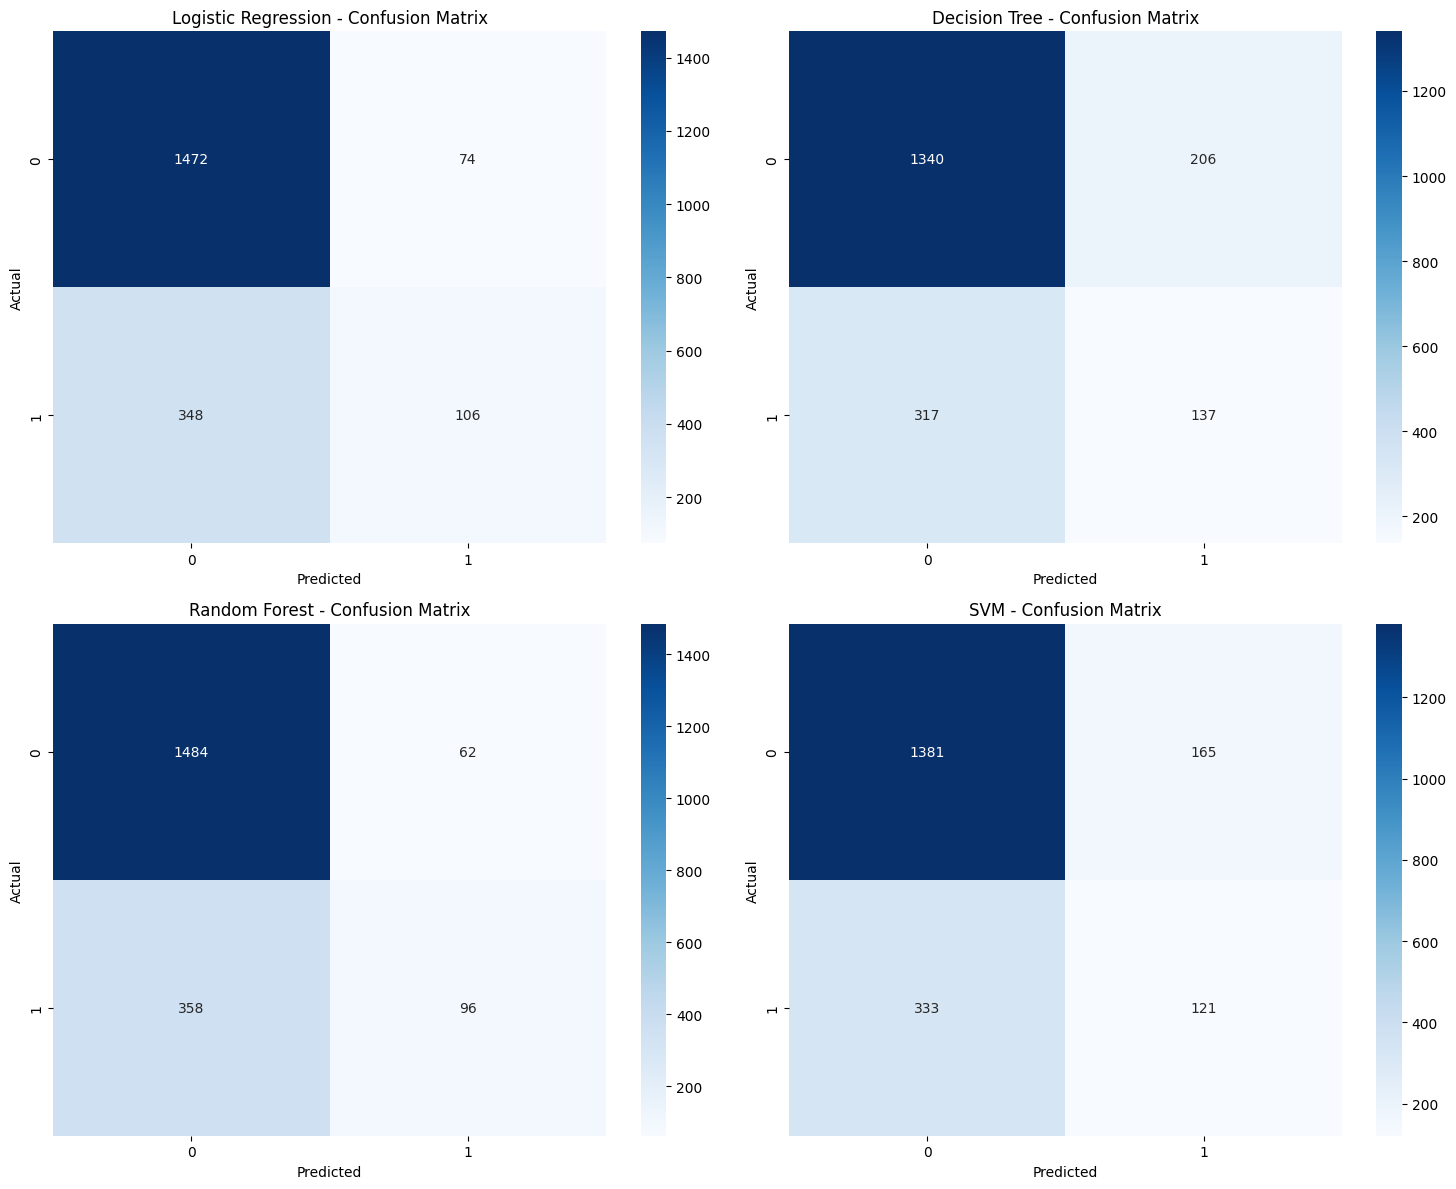


Best Model: Decision Tree
Best F1-Score on validation set: 0.3438

FINAL EVALUATION ON TEST SET
Final Test Results for Decision Tree:
Accuracy:  0.7490
Precision: 0.4310
Recall:    0.3304
F1-Score:  0.3741


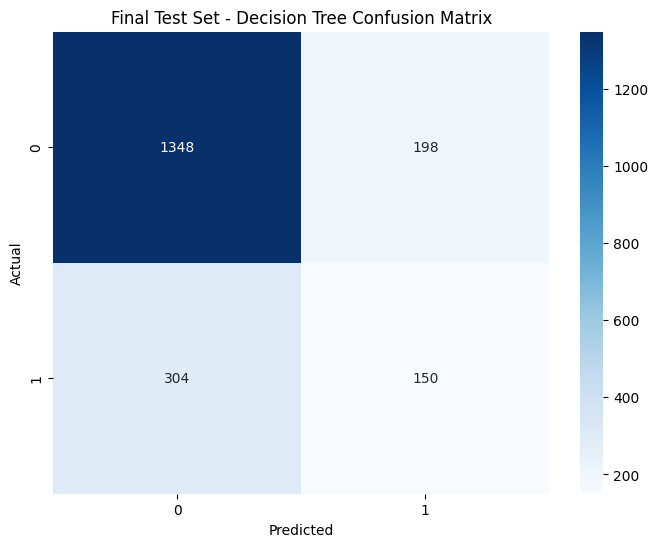


Detailed Classification Report for Decision Tree:
              precision    recall  f1-score   support

    No Churn       0.82      0.87      0.84      1546
       Churn       0.43      0.33      0.37       454

    accuracy                           0.75      2000
   macro avg       0.62      0.60      0.61      2000
weighted avg       0.73      0.75      0.74      2000


Top 10 Most Important Features for Decision Tree:
                feature  importance
5                tenure    0.135998
18      monthly_charges    0.132012
19        total_charges    0.119575
24     low_satisfaction    0.113624
0                   age    0.109200
15             contract    0.079656
22  avg_monthly_charges    0.055617
21        support_calls    0.041068
17       payment_method    0.019865
3               partner    0.018845


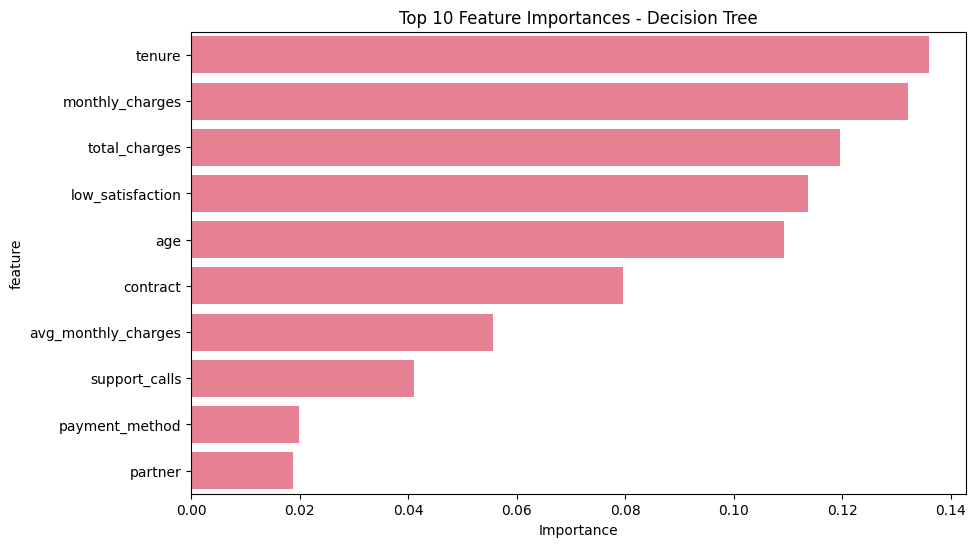


ANALYSIS COMPLETED SUCCESSFULLY!


In [17]:
# Evaluate models on validation set
results = {}

print("Evaluating models on validation set...")
print("-" * 80)

for name, model in best_models.items():
    # Use appropriate data (scaled or not)
    if name in ['SVM', 'Logistic Regression']:
        X_val_use = X_val_scaled
    else:
        X_val_use = X_val
    
    # Make predictions
    y_pred = model.predict(X_val_use)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

# Create results comparison DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Comparison Summary:")
print(results_df.round(4))

# Create confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (name, model) in enumerate(best_models.items()):
    # Use appropriate data
    if name in ['SVM', 'Logistic Regression']:
        X_val_use = X_val_scaled
    else:
        X_val_use = X_val
    
    y_pred = model.predict(X_val_use)
    cm = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name} - Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Select best model based on F1-score
best_model_name = max(results, key=lambda x: results[x]['F1-Score'])
best_model = best_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best F1-Score on validation set: {results[best_model_name]['F1-Score']:.4f}")

# Final evaluation on test set
print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

# Use appropriate data for best model
if best_model_name in ['SVM', 'Logistic Regression']:
    X_test_use = X_test_scaled
else:
    X_test_use = X_test

# Make final predictions
y_test_pred = best_model.predict(X_test_use)

# Calculate final metrics
final_accuracy = accuracy_score(y_test, y_test_pred)
final_precision = precision_score(y_test, y_test_pred)
final_recall = recall_score(y_test, y_test_pred)
final_f1 = f1_score(y_test, y_test_pred)

print(f"Final Test Results for {best_model_name}:")
print(f"Accuracy:  {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall:    {final_recall:.4f}")
print(f"F1-Score:  {final_f1:.4f}")

# Final confusion matrix
plt.figure(figsize=(8, 6))
final_cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Final Test Set - {best_model_name} Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, y_test_pred, target_names=['No Churn', 'Churn']))

# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features for {best_model_name}:")
    print(feature_importance.head(10))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.show()

elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_model.coef_[0]
    })
    feature_importance['abs_coefficient'] = abs(feature_importance['coefficient'])
    feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
    
    print(f"\nTop 10 Most Important Features for {best_model_name} (by coefficient magnitude):")
    print(feature_importance[['feature', 'coefficient']].head(10))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='abs_coefficient', y='feature')
    plt.title(f'Top 10 Feature Coefficients (Absolute Values) - {best_model_name}')
    plt.xlabel('Absolute Coefficient Value')
    plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*60)